## Pytorch LSTM Based Classification

In [ ]:
#!pip install --quiet torch==1.8.1

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install --quiet pytorch-lightning==1.2.6

In [ ]:
!pip install torchtext==0.8.0 torch==1.7.1 pytorch-lightning==1.2.2

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch 
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.metrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE","#FFDD00","#FF7D00","#FF006D","#ADFF02","#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 16,10

In [4]:
pl.seed_everything(42)

Global seed set to 42


42

In [72]:
X_train = pd.read_csv('/content/drive/MyDrive/PAM_AP2_Dataset/x_trn.csv')
y_train = pd.read_csv('/content/drive/MyDrive/PAM_AP2_Dataset/y_trn.csv')

In [35]:
len(X_train)

77484

In [36]:
len(y_train)

107484

In [73]:
y_train = y_train.sample(n=7044,replace=True)

In [39]:
y_train.head()

,Unnamed: 0,time_stamp,activity_id,id
15795,184757,1855.95,12,101
860,155141,1559.79,12,101
103694,358010,3588.48,24,101
76820,316255,3170.93,5,101
54886,255019,2558.57,7,101


In [ ]:
X_train.head()

In [ ]:
y_train.head()

In [74]:
y_train.rename(columns = {'activity_id':'surface'}, inplace = True)
y_train.head()

,Unnamed: 0,time_stamp,surface,id
30625,199587,2004.25,13,101
47035,240005,2408.43,4,101
1593,155874,1567.12,12,101
55873,256006,2568.44,7,101
55153,255286,2561.24,7,101


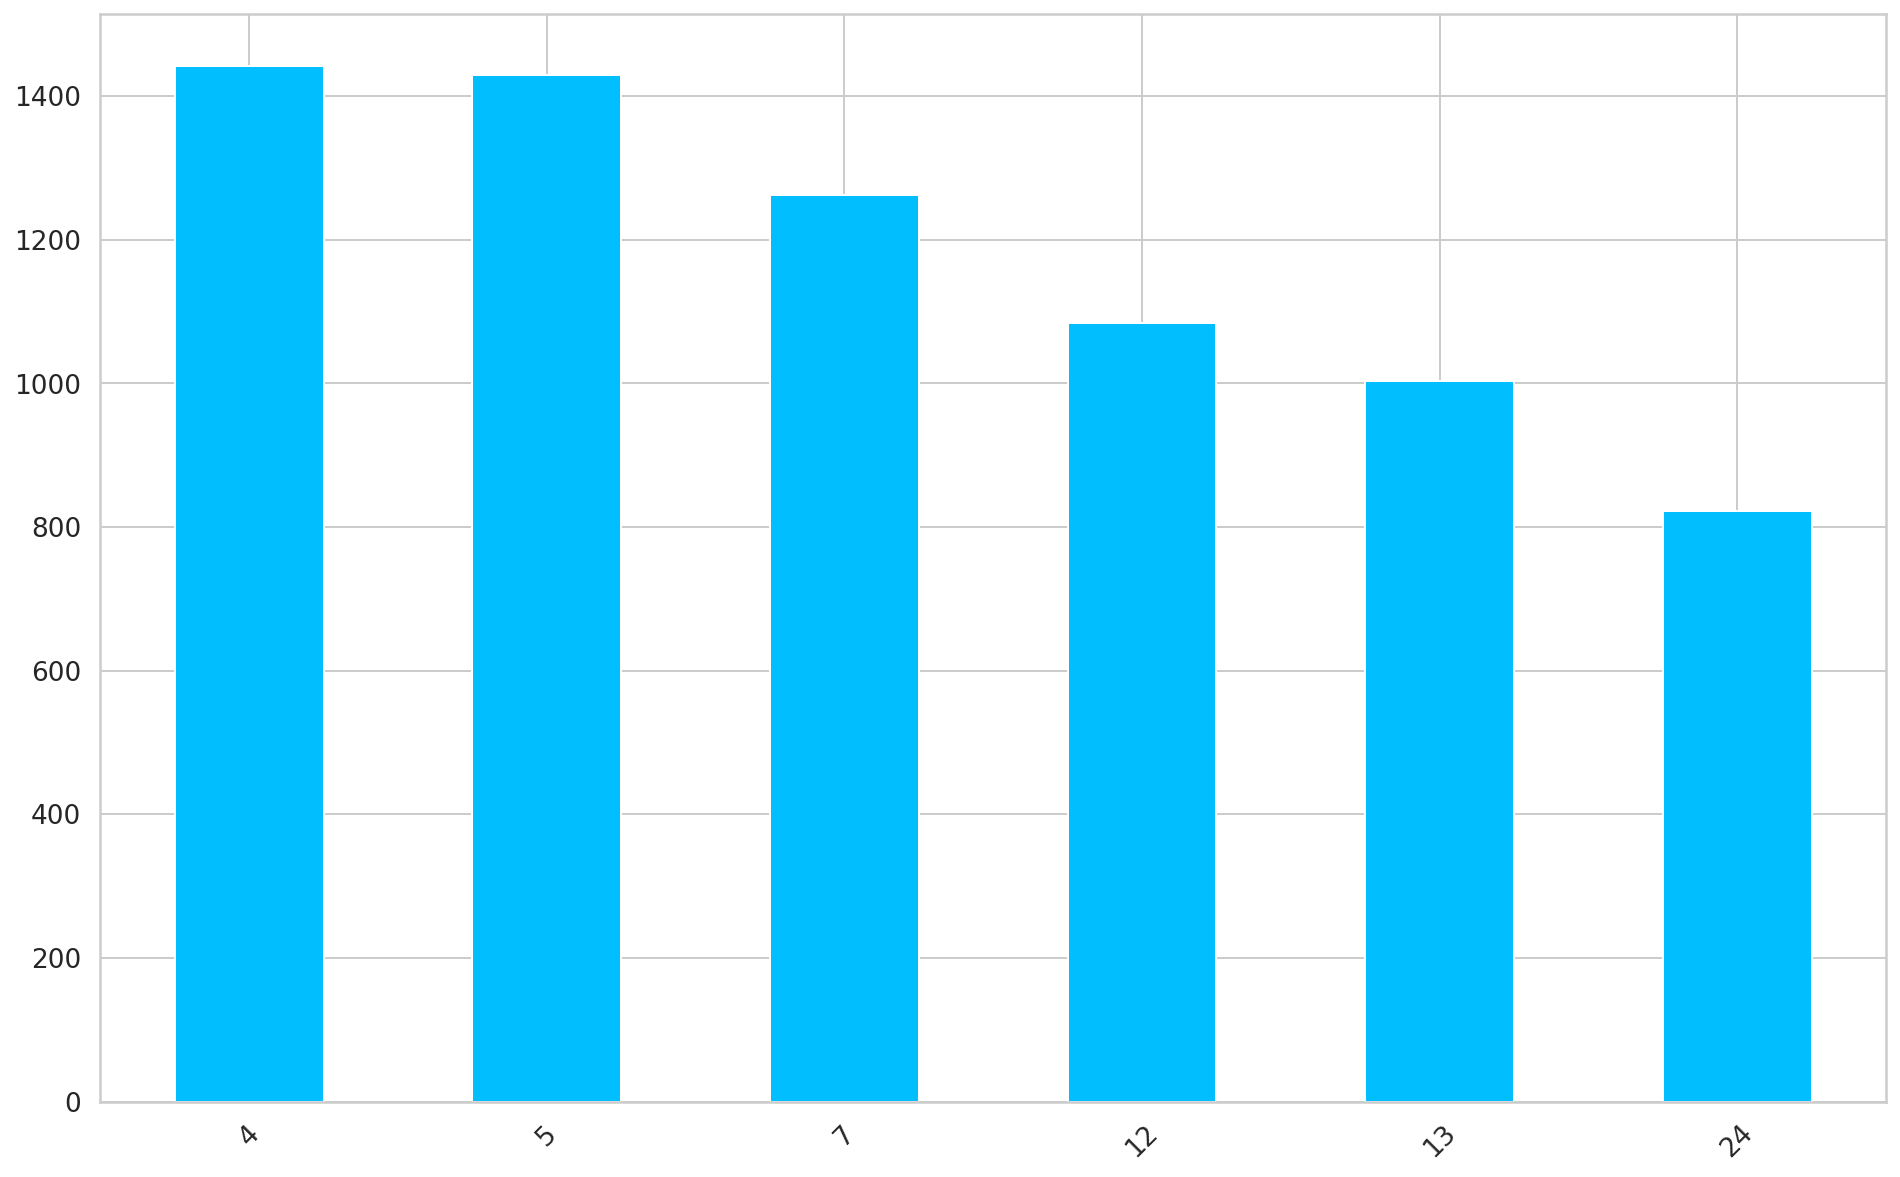

In [41]:
y_train.surface.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show();

## Pre-processing

In [75]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train.surface)

In [76]:
encoded_labels[:10]

array([4, 0, 3, 2, 2, 1, 4, 0, 0, 3])

In [77]:
label_encoder.classes_

array([ 4,  5,  7, 12, 13, 24])

In [78]:
y_train["label"] = encoded_labels

In [79]:
y_train['series_id'] = np.arange(len(y_train))
y_train.head()


,Unnamed: 0,time_stamp,surface,id,label,series_id
30625,199587,2004.25,13,101,4,0
47035,240005,2408.43,4,101,0,1
1593,155874,1567.12,12,101,3,2
55873,256006,2568.44,7,101,2,3
55153,255286,2561.24,7,101,2,4


In [ ]:
#y_train.head()

In [80]:
len(X_train)

77484

In [81]:
len(y_train)

7044

In [87]:
ntimes = 11 # number of times you repeat each item
yourlist = [*range(0, 7044, 1)]
print(len(yourlist))
X_train['series_id'] = [i for i in yourlist for _ in range(ntimes)]

7044


In [88]:
X_train.head()

,Unnamed: 0,time_stamp,ankle_3D_acceleration_16_x,ankle_3D_acceleration_16_y,ankle_3D_acceleration_16_z,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,series_id
0,154281,1551.19,9.75372,-1.04280,-0.835833,9.80851,-1.01234,-0.600316,-0.010195,-0.010306,-0.009147,0
1,154282,1551.20,9.78375,-1.19298,-1.066130,9.73352,-1.02744,-0.569598,0.000103,-0.008209,-0.006737,0
2,154283,1551.21,9.86120,-1.11816,-0.988621,9.77851,-1.07282,-0.584827,-0.003771,-0.024143,0.008858,0
3,154284,1551.22,9.71020,-1.15486,-1.028530,9.77858,-1.04256,-0.569789,-0.009096,0.049125,0.004017,0
4,154285,1551.23,9.78246,-1.23063,-1.104500,9.77875,-1.10300,-0.524190,-0.041132,0.005700,0.014554,0


In [ ]:
X_train.series_id.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show();

In [90]:
FEATURE_COLUMNS = X_train.columns.tolist()[2:11]
FEATURE_COLUMNS

['ankle_3D_acceleration_16_x',
 'ankle_3D_acceleration_16_y',
 'ankle_3D_acceleration_16_z',
 'ankle_3D_acceleration_6_x',
 'ankle_3D_acceleration_6_y',
 'ankle_3D_acceleration_6_z',
 'ankle_3D_gyroscope_x',
 'ankle_3D_gyroscope_y',
 'ankle_3D_gyroscope_z']

In [91]:
X_train.series_id.value_counts()

2047    11
597     11
6550    11
4503    11
2516    11
        ..
1322    11
3371    11
5480    11
1386    11
0       11
Name: series_id, Length: 7044, dtype: int64

In [92]:
(X_train.series_id.value_counts() == 11).sum()

7044

In [93]:
(X_train.series_id.value_counts() == 11).sum() == len(y_train)

True

In [94]:
sequences = []

for series_id, group in X_train.groupby('series_id'):
  sequence_features = group[FEATURE_COLUMNS]
  label = y_train[y_train.series_id == series_id].iloc[0].label

  sequences.append((sequence_features, label))

In [95]:
sequences[0]

(    ankle_3D_acceleration_16_x  ...  ankle_3D_gyroscope_z
 0                      9.75372  ...             -0.009147
 1                      9.78375  ...             -0.006737
 2                      9.86120  ...              0.008858
 3                      9.71020  ...              0.004017
 4                      9.78246  ...              0.014554
 5                      9.82538  ...             -0.030301
 6                      9.86340  ...             -0.020229
 7                      9.67918  ...              0.002065
 8                      9.74892  ...              0.002128
 9                      9.78945  ...             -0.006665
 10                     9.78435  ...             -0.009630
 
 [11 rows x 9 columns], 4.0)

In [96]:
train_sequences, test_sequences = train_test_split(sequences, test_size=0.99)

In [97]:
len(train_sequences), len(test_sequences)

(70, 6974)

## Dataset

In [98]:
class SurfaceDataset(Dataset):

  def __init__(self, sequences):
    self.sequences = sequences
  
  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, idx):
    sequence, label = self.sequences[idx]
    return dict(
        sequence=torch.Tensor(sequence.to_numpy()),
        label=torch.tensor(label).long()
    )

In [99]:
class SurfaceDataModule(pl.LightningDataModule):

  def __init__(self, train_sequences, test_sequences, batch_size):

    super().__init__()
    self.train_sequences=train_sequences
    self.test_sequences=test_sequences
    self.batch_size=batch_size

  def setup(self, stage = None):
    self.train_dataset = SurfaceDataset(self.train_sequences)
    self.test_dataset = SurfaceDataset(self.test_sequences)

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=cpu_count()
    )

  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=cpu_count()
    )

  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=cpu_count()
    )




In [100]:
N_EPOCHS = 2
BATCH_SIZE = 64

data_module = SurfaceDataModule(train_sequences, test_sequences, BATCH_SIZE)

## Pytorch LSTM

In [102]:
class SequenceModel(nn.Module):

  def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
    super().__init__()

    #self.n_hidden = n_hidden

    self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        batch_first=True,
        dropout=0.75
    )

    self.classifier = nn.Linear(n_hidden, n_classes)

  def forward(self, x):

    self.lstm.flatten_parameters()
    _, (hidden, _) = self.lstm(x)

    out = hidden[-1]
    return self.classifier(out)

In [103]:
class SurfacePredictor(pl.LightningModule):

  def __init__(self, n_features, n_classes: int):
    super().__init__()
    self.model = SequenceModel(n_features, n_classes)
    self.criterion = nn.CrossEntropyLoss()

  def forward(self, x, labels=None):

    output = self.model(x)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    sequences = batch["sequence"]
    labels = batch['label']
    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(predictions, labels)

    self.log("train_loss", loss, prog_bar=True, logger=True)
    self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
    return {"loss" : loss, "accuracy" : step_accuracy}

  def validation_step(self, batch, batch_idx):
    sequences = batch["sequence"]
    labels = batch['label']
    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(predictions, labels)

    self.log("val_loss", loss, prog_bar=True, logger=True)
    self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)
    return {"loss" : loss, "accuracy" : step_accuracy}

  def test_step(self, batch, batch_idx):
    sequences = batch["sequence"]
    labels = batch['label']
    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_accuracy = accuracy(predictions, labels)

    self.log("test_loss", loss, prog_bar=True, logger=True)
    self.log("test_accuracy", step_accuracy, prog_bar=True, logger=True)
    return {"loss" : loss, "accuracy" : step_accuracy}

  def configure_optimizers(self):
    return optim.Adam(self.parameters(), lr = 0.0001)



In [106]:
model = SurfacePredictor(
    n_features = len(FEATURE_COLUMNS),
    n_classes = len(label_encoder.classes_)
)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./Lightning_logs

In [107]:
checkpoint_callback = ModelCheckpoint(
    dirpath= 'checkpoints',
    filename='best-checkpoint',
    save_top_k = 1,
    verbose=True,
    monitor="val_loss",
    mode = "min"

)

logger = TensorBoardLogger("Lightning_logs", name="surface")

trainer = pl.Trainer(
    logger = logger,
    checkpoint_callback= checkpoint_callback,
    max_epochs= N_EPOCHS,
    gpus= 0,
    progress_bar_refresh_rate=30

    
)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


In [108]:
trainer.fit(model, data_module)


  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SequenceModel    | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.310     Total estimated model params size (MB)


Epoch 0, global step 1: val_loss reached inf (best inf), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Epoch 1, step 3: val_loss was not in top 1


1

In [ ]:
trainer.test()


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.21666666865348816,
 'loss': 2.1706924438476562,
 'test_accuracy': 0.13467656075954437,
 'test_loss': 2.1817288398742676}
--------------------------------------------------------------------------------


[{'accuracy': 0.21666666865348816,
  'loss': 2.1706924438476562,
  'test_accuracy': 0.13467656075954437,
  'test_loss': 2.1817288398742676}]

## Predictions

In [109]:
trained_model = SurfacePredictor.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_features=len(FEATURE_COLUMNS),
    n_classes= len(label_encoder.classes_)
)

trained_model.freeze()

In [110]:
test_dataset = SurfaceDataset(test_sequences)

predictions = []
labels = []

for item in tqdm(test_dataset):

  sequence= item["sequence"]
  label = item["label"]

  _, output = trained_model(sequence.unsqueeze(dim=0))
  prediction = torch.argmax(output, dim=1)
  predictions.append(prediction.item())
  labels.append(label.item())


In [128]:
def show_confusion_matrix(confusion_matrix):

  hmap = sns.heatmap(confusion_matrix, annot=True, fmt= "d", cmap= "Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation= 0, ha = 'right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation= 30, ha = 'right')
  plt.ylabel('Excepted Activity')
  plt.xlabel('Predicted Activity');

In [129]:
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score

In [120]:
print("Accuracy:", metrics.accuracy_score(labels, predictions))

Accuracy: 0.19845139088041297


In [125]:
print("Precision:", metrics.precision_score(labels, predictions, average='macro'))

Precision: 0.08214924584615318


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [127]:
print("Recall:", metrics.recall_score(labels, predictions,average='macro'))

Recall: 0.16694788123693685


In [117]:
cm = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(
    cm, index= ['Walking','Running','Nordic Walking','Ascending Stairs','Descending Stairs','Rope Jumping'], columns=['Walking','Running','Nordic Walking','Ascending Stairs','Descending Stairs','Rope Jumping']
)
df_cm

,Walking,Running,Nordic Walking,Ascending Stairs,Descending Stairs,Rope Jumping
Walking,35,1413,4,0,0,0
Running,30,1348,2,0,0,0
Nordic Walking,35,1261,1,0,0,0
Ascending Stairs,21,1002,1,0,0,0
Descending Stairs,31,992,2,0,0,0
Rope Jumping,20,775,1,0,0,0


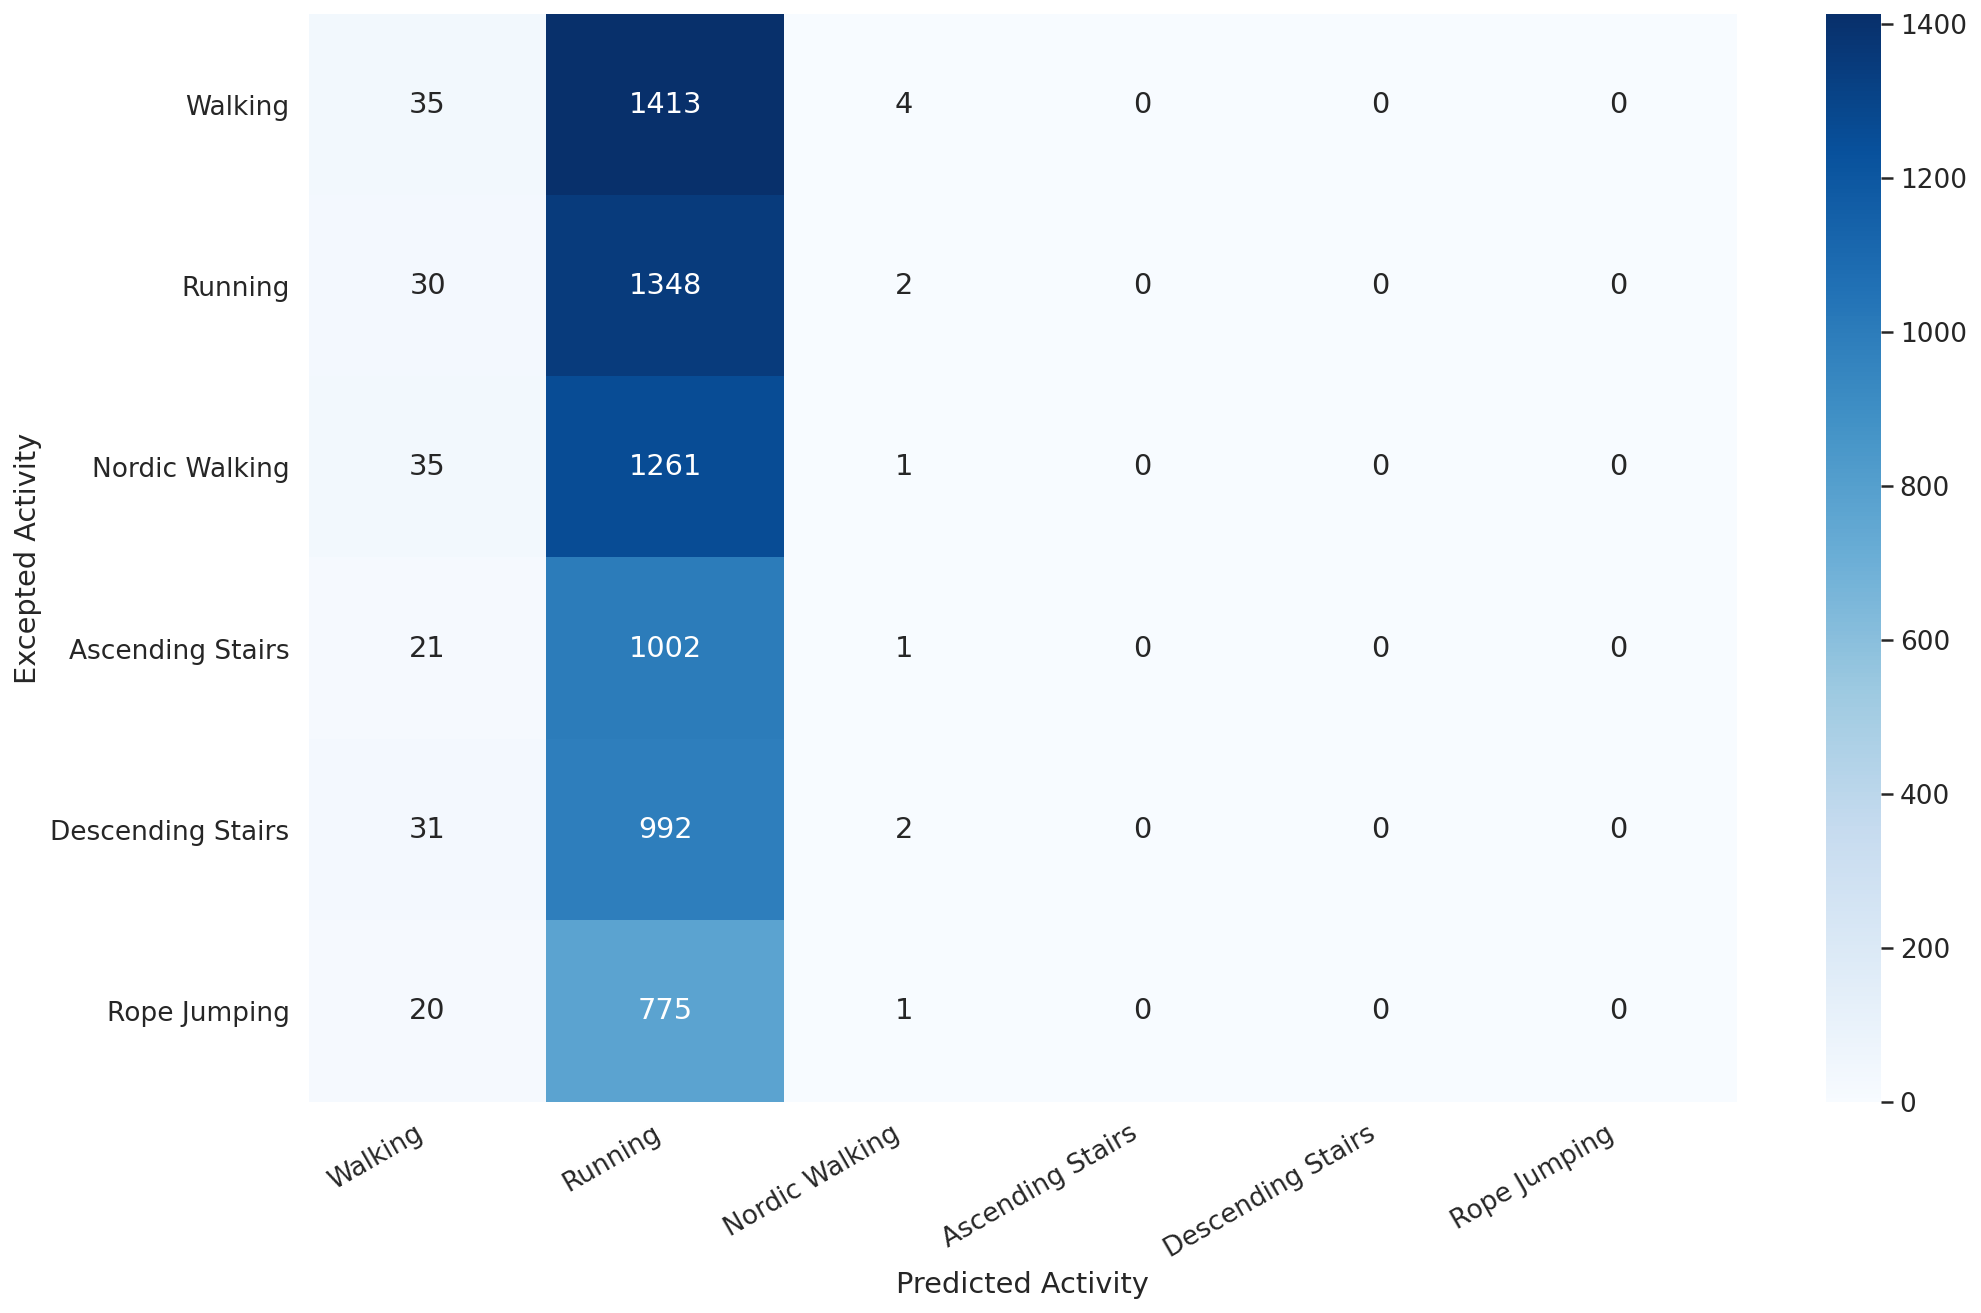

In [130]:
show_confusion_matrix(df_cm)